$\#\#\#\#\#\#\#$ Libraries $\#\#\#\#\#\#\#$

In [235]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn import pipeline 
from PIL import Image

from nltk.corpus import PlaintextCorpusReader , stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob


from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler

$\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#$

# Data

#### First dataset

The dataset for the first exercise will be the one with the airplane delays already used on the last exercises. The version will be the modified one from sprint 2 task 5.

In [94]:
df = pd.read_csv('DelayedFlights_Mod.csv')

In [99]:
# Transforming data in cyclic for timestamp/timedate built-in functions. 
# we make use of the columns DepTime, CRSDepTime, ArrTime, CRSArrTime to know the hours for the date transformation.
# we can notice that afterwards we can drop these columns.
df['Year'] = 2008 # we add the column of year, previously erased, will be dropped afterwards.
df['DateDep'] = df.DepTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000
df['DateCRSDep'] = df.CRSDepTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000
df['DateArr'] = df.ArrTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000
df['DateCRSArr'] = df.CRSArrTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000

In [98]:
# we also transform the categorical/object type variable
encode = LabelEncoder()
df['UCarrier_en'] = encode.fit_transform(df['UniqueCarrier'])
df['TailNum_en'] = encode.fit_transform(df['TailNum'])
df['Origin_en'] = encode.fit_transform(df['Origin'])
df['Dest_en'] = encode.fit_transform(df['Dest'])

In [101]:
df.drop(['Unnamed: 0', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 
         'UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'Year'], axis=1, inplace=True)

In [102]:
df.columns

Index(['FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
       'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'VelocityAir', 'DelayedArr', 'TotalDelayed', 'TaxiTime', 'UCarrier_en',
       'TailNum_en', 'Origin_en', 'Dest_en', 'DateDep', 'DateCRSDep',
       'DateArr', 'DateCRSArr'],
      dtype='object')

#### Second dataset

The text [1] used for this exercises is a lovely fanfiction of the Silmarillion by [TheLCM](https://archiveofourown.org/chapters/37461809), not finished, since it only it is the first chapter it is short enough to use.

[1] Since I was unable to find Akallabeth (which in Andunic means the Fall of Numeror) on txt, or any tale of the Silmarillion.

In [163]:
# set the path
corpus_root = '/home/izzy/Documents/DataScience-Course/tema12'
# load text
data = PlaintextCorpusReader(corpus_root, '.*')
#data.fileids()
df2 = data.words('Ugarthist.txt')
print('this text contains ', len(df2), 'words')
df2[24:50]

this text contains  4113 words


['Elessar',
 ',',
 'King',
 'of',
 'Gondor',
 ',',
 'called',
 'soldiers',
 'to',
 'the',
 'ruined',
 'vaults',
 'of',
 'Barad',
 '-',
 'dûr',
 'and',
 'slew',
 'the',
 'foul',
 'things',
 'lingering',
 'there',
 ',',
 'so',
 'that']

# Nivell 1

## Exercici 1: Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.

Since our goal it is to use the pipeline and gridsearch, we will drop the categorical features, all but DelayedArr, since we can standarize the data.

In [112]:
df.drop(['FlightNum', 'UCarrier_en', 'TailNum_en','Origin_en', 'Dest_en', 'DateDep', 'DateCRSDep', 'DateArr',
         'DateCRSArr'], axis=1, inplace=True)

In [113]:
X = df.drop('DelayedArr', axis = 1)
y = df['DelayedArr']
X.columns

Index(['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'VelocityAir', 'TotalDelayed', 'TaxiTime'],
      dtype='object')

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3,random_state=42, shuffle=True,
                                                   stratify=y)

In [121]:
pipe1 = pipeline.Pipeline([('scaled', RobustScaler()),
                          ('rfc', RandomForestClassifier(random_state=42))])

In [136]:
# write the parameters to use in the estimator:
param_rf = [{'rfc__n_estimators' : [100, 110],
             'rfc__criterion': ['gini', 'entropy'],
             'rfc__max_depth': [20, 50]
            }]
# we extract complexity in the computation sustracting these two parameters, also we use cv=default(5).
#             'rfc__min_samples_split': [2, 3],
#             'rfc__min_samples_leaf': [3, 5]

# n_jobs:
jobs = -1

grid1 = GridSearchCV(estimator=pipe1,
                     param_grid= param_rf,
                     scoring='accuracy',
                     verbose=3,
                     n_jobs=jobs)

In [137]:
grid1.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=Pipeline(steps=[('scaled', RobustScaler()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'rfc__criterion': ['gini', 'entropy'],
                          'rfc__max_depth': [20, 50],
                          'rfc__n_estimators': [100, 110]}],
             scoring='accuracy', verbose=3)

In [145]:
# get the best parameters:
grid1.best_params_

{'rfc__criterion': 'gini', 'rfc__max_depth': 20, 'rfc__n_estimators': 100}

In [146]:
# best training accuracy:
grid1.best_score_

1.0

In [153]:
#predict train set:
yprtrain = grid1.predict(X_train)

# get the score for test:
print('accuracy score train:', metrics.accuracy_score(y_train, yprtrain))
# Mean squared Error:
print('MSE for train', metrics.mean_squared_error(y_train, yprtrain))

accuracy score train: 1.0
MSE for train 0.0


In [152]:
# now we predict the result:
ypred = grid1.predict(X_test)

# get the score for test:
print('accuracy score test:', metrics.accuracy_score(y_test, ypred))
# Mean squared Error:
print('MSE for test', metrics.mean_squared_error(y_test, ypred))

accuracy score test: 1.0
MSE for test 0.0


In [149]:
# resume and scores:

MSE for test 0.0
[CV 2/5] END rfc__criterion=gini, rfc__max_depth=20, rfc__n_estimators=100;, score=1.000 total time= 2.4min
[CV 3/5] END rfc__criterion=gini, rfc__max_depth=50, rfc__n_estimators=100;, score=1.000 total time= 2.2min
[CV 3/5] END rfc__criterion=gini, rfc__max_depth=50, rfc__n_estimators=110;, score=1.000 total time= 2.4min
[CV 5/5] END rfc__criterion=entropy, rfc__max_depth=20, rfc__n_estimators=100;, score=1.000 total time= 2.2min
[CV 3/5] END rfc__criterion=entropy, rfc__max_depth=50, rfc__n_estimators=100;, score=1.000 total time= 2.2min
[CV 4/5] END rfc__criterion=gini, rfc__max_depth=20, rfc__n_estimators=100;, score=1.000 total time= 2.3min
[CV 1/5] END rfc__criterion=gini, rfc__max_depth=50, rfc__n_estimators=100;, score=1.000 total time= 2.3min
[CV 2/5] END rfc__criterion=gini, rfc__max_depth=50, rfc__n_estimators=110;, score=1.000 total time= 2.4min
[CV 1/5] END rfc__criterion=entropy, rfc__max_depth=20, rfc__n_estimators=110;, score=1.000 total time= 2.5min
[C

## Exercici 2: Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules

Taking the work of TheLCM, we will perform the get the word frequencies with the function FreqDist and we will plot the cumulative graph of the first 50 more used words. The function counts the punctuation and the stopwords (like: the, to, also, etc.). 

In [160]:
# before getting the frequencies we can see if how high it is the lexical diversity:
len(df2) / len(set(df2))

3.732304900181488

This score tells us that each word is used around 4 times on average on the whole text.

In [171]:
# first we need to remove puntuation signs, to do so we use tokenize function
# We don't have to tokenize the text since we have imported it with PlaintextCorpusReader
# so we can directly remove the punctuation:
df2t = [w for w in df2 if w.isalnum()]

['forces', 'objects', 'both', 'good', 'ill', 'borne', 'from', 'pyres', 'Greatest', 'most', 'terrible', 'seven', 'tomes', 'written', 'hand', 'himself', 'numbered', 'black', 'speech', 'which', 'elves', 'remained', 'later', 'named', 'or', 'Lore', 'Unclean', 'Things', 'HISTORIES', 'ONE', 'Ainulindalë', 'said', 'beginning', 'Great', 'Awarenesses', 'Valinor', 'are', 'Ainur', 'slept', 'Flame']


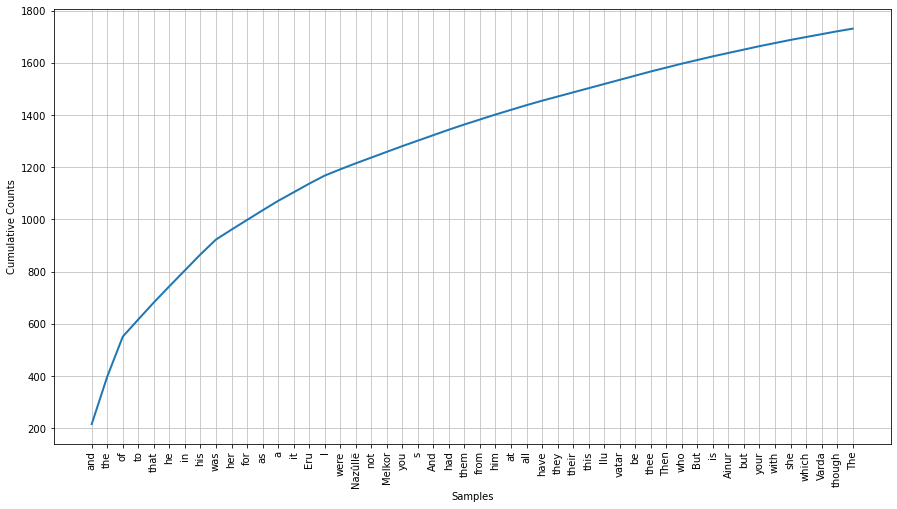

In [172]:
fdist = FreqDist(df2t)
vocabulary1 = list(fdist.keys())
print(vocabulary1[100:140]) # see the 100th to 140th more frequent words in the text.

# graph of the frequencies of the 50 more frequent words:
plt.figure(figsize=(15,8))
fdist.plot(50, cumulative=True)
plt.show()

Let's see the frequency of one word, for example Melkor.

In [155]:
# frequency of a word:
fdist['Melkor']

22

In [244]:
fdist['Manwë']

5

We have found that this text has 4113 words, the cumulative function (graph above) shows us that the 50 most used words made around 2000-2250 words of the text, which it is nearly half of it. Even though the richness of the text, the author has only used the same word an average of 4 times.

In [164]:
4113 / 2

2056.5

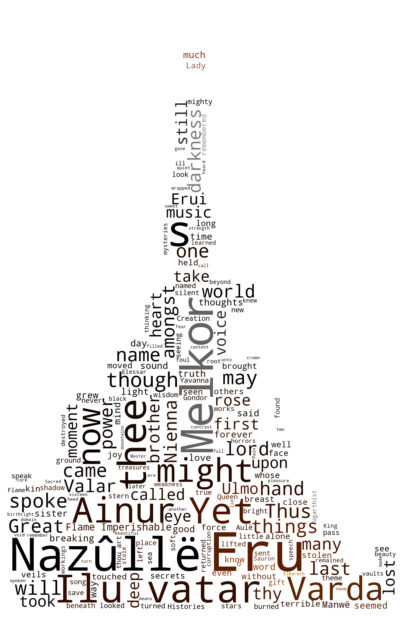

In [245]:
# for this one we need to load the file in text format an not in list like as we had done it, we use the open
fic = open('Ugarthist.txt','r').read()
# make mask
tower_mask = np.array(Image.open("baraddur3.png"))
# wordcloud
wordcloud = WordCloud(background_color='white', mode='RGBA', mask=tower_mask).generate(fic)

#color for the image:
image_colors=ImageColorGenerator(tower_mask)

# Display the generated image:
plt.figure(figsize=(7,17))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

*Tries to be Barad-Dur... but it kinda fails horribly

# Nivell 2

## Exercici 1: Treu les stopwords i realitza stemming al teu conjunt de dades.


Now, let's extract the "stopwords" from the text. The stopwords are the words that link the text, pronouns and adverbs. Example:

In [ ]:
# since our text it is in english
#stopwords.words('english') 

In [213]:
# if we wanted to normalize the text, we set them all lowercaps
df2norm = set(w.lower() for w in df2t)

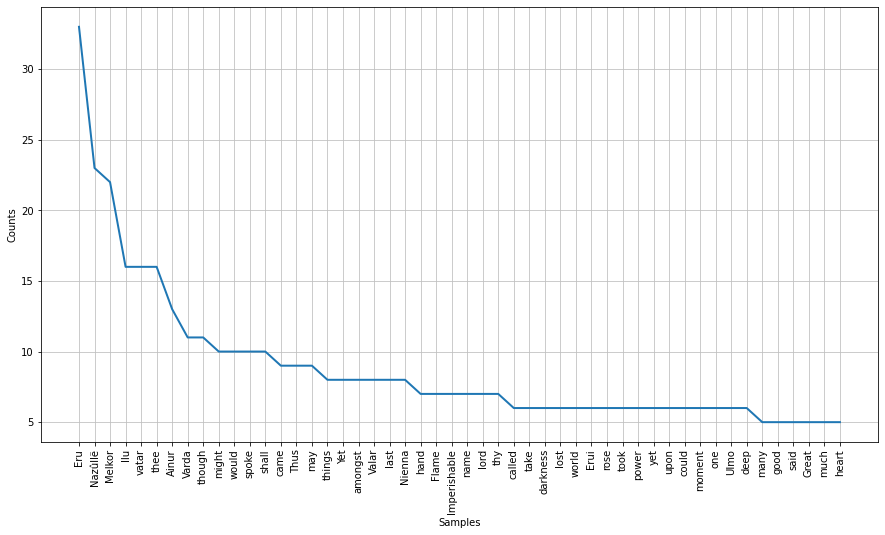

In [227]:
dfcon = [w for w in df2t if w.lower() not in stopwords.words('english')]

# word frequency
fdist2 = FreqDist(dfcon)

#plot the 50 most common words in the text:
plt.figure(figsize=(15,8))
fdist2.plot(50, cumulative=False)
plt.show()

In this case, since we have done the extraction of stopwords and punctuation we show the frequency of each word instead of the cumulative function.

Now, we will do Stemming. Since we hadn't already done, but we have used to extract the stopwords, we normalize the text:

There are two stemmer functions on the NLTK library: Porter and Lancaster. Lancaster tends to strip less well the characters, on the book: "Natural Language Processing with Python" we can see an example of it and its treatement of the word "lying", Lancaster keeps it as it, while Porter changes it to "Lie", giving the impression that Porter is better than Lancaster.

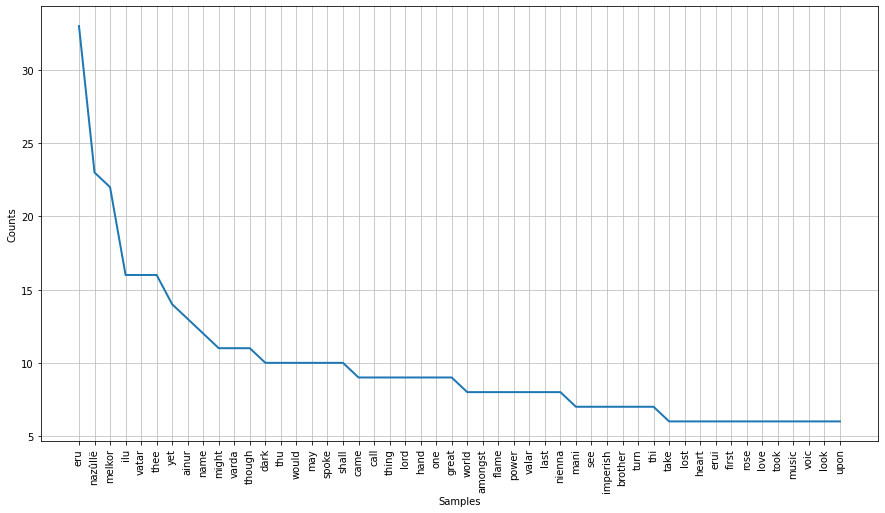

In [226]:
# define the stemming:
porter = PorterStemmer()
# now stem that!
dfStem = [porter.stem(w) for w in dfcon]
# count frequencies
fdist3 = FreqDist(dfStem)

# plot it!
plt.figure(figsize=(15,8))
fdist3.plot(50, cumulative=False)
plt.show()

# Nivell 3

## Exercici 1: Realitza sentiment analysis al teu conjunt de dades.

We will use 2 different analysers: Vader (because has a cool name) although usually it is used in Twitter analysis. And textblob, that it is more indicate for "books", since the score takes it more into account.

In [237]:
# set up the analyser
analyser = SentimentIntensityAnalyzer()

# see what Vader thinks about this text...
feelings = analyser.polarity_scores(fic)
print('Vader ranks this text as: \n{}'.format(str(feelings)))

Vader ranks this text as: 
{'neg': 0.126, 'neu': 0.741, 'pos': 0.133, 'compound': 0.9946}


In [238]:
# what it is its feelings?
feels = TextBlob(fic)
print('TextBlob says: \n{}'.format(feels.sentiment))

TextBlob says: 
Sentiment(polarity=0.15771697438364102, subjectivity=0.5567381692381694)


This fic (not a book or story) is about the 'Ainulindalë and Valaquenta' (Music of Ainur and Valar, first book of Silmarillion) but from the point of view of the Dark Lord Sauron, which in the First Age was Liutetant of the Dark Lord Melkor.

The text it is written with a very neutral background, as both analysers indicate, TextBlob around $0$ in polarity indicates neutrality, since polarity is defined in the range of $[-1,1]$ where $1$ is positivity and $-1$ negativity. In Vader we have these values separated and we can see that negativity and positivity are low compared to neutrality.

If we read the text we could see that the author, that they are writing the story if they were Sauron, tends to lend towards the neutrality **but** also the negativity (or rage, mainly). The text was meant to be sarcastic and have dark humor, and seems that the analyser only categorizes less complex sentiments.

The subjectivity in the text is around $0.6$, which means that the text tends to be subjective instead of being an ennumeration of the "events", which the TextBlob has detected very well, since the author tends to use the voice of Sauron to criticize specially Eru, but also, Varda, Manwe and the "good" gods.
